In [1]:
import numpy as np
import math
import optuna
from optuna.samplers import TPESampler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf
from tensorflow.keras.optimizers import Adam

In [2]:
# Fetching HSI data using yfinance
start_date = '2004-03-13'
end_date = '2024-03-14'
symbols = ['^HSI']
HSI_data = yf.download(symbols, start=start_date, end=end_date)

HSI_data = HSI_data[['Volume']]
HSI_training_data_len = math.ceil(len(HSI_data)*0.8)



[*********************100%***********************]  1 of 1 completed


In [3]:
# Define a new scaler for 'Adj Close'
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = target_scaler.fit_transform(HSI_data)

# Split data into training and testing sets
train_data = scaled_data[:HSI_training_data_len]
test_data = scaled_data[HSI_training_data_len:]


In [4]:
# Define the create_sequences function
def create_sequences(features, target, step):
    x, y = [], []
    for i in range(len(features) - step):
        x.append(features[i:(i + step)])
        y.append(target[i + step])
    return np.array(x), np.array(y)

In [5]:
# # Define the Optuna objective function
# def objective(trial):
#     # Define search space
#     step = trial.suggest_int("step", 10, 60)
#     lstm_units = trial.suggest_int("lstm_units", 32, 64)
#     dense_units = trial.suggest_int("dense_units", 16, 64)
#     epochs = trial.suggest_int("epochs", 10, 100)
#     batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
#     learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    
#     x_train, y_train = create_sequences(train_data, train_data, step)
#     x_test, y_test = create_sequences(test_data, test_data, step)
    
#     model = Sequential()
#     model.add(LSTM(lstm_units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
#     model.add(LSTM(lstm_units, return_sequences=False))
#     model.add(Dense(dense_units))
#     model.add(Dense(1))
    
#     optimizer = 'adam'
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
    
#     model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, verbose=0)
    
#     val_loss = model.evaluate(x_test, y_test)
    
#     return val_loss

# # Running the optimization
# sampler = TPESampler(seed=10)
# study = optuna.create_study(direction="minimize", sampler=sampler)
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# best_rmse = study.best_value

# print(f"Best RMSE: {best_rmse} with params={best_params}")

In [6]:
# Create the training dataset
train_data = scaled_data[0:HSI_training_data_len, :]
x_train = []
y_train = []

# Create sequences
step = 17  # Optimal step value
for i in range(step, len(train_data)):
    x_train.append(train_data[i - step:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Define best parameters
lstm_units = 34
dense_units = 53
epochs = 90
batch_size = 64
learning_rate = 0.006837405994037031

# Build the LSTM model with best parameters
model = Sequential()
model.add(LSTM(lstm_units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dense(dense_units))
model.add(Dense(1))
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/90
62/62 [==============================] - 6s 10ms/step - loss: 0.0048
Epoch 2/90
62/62 [==============================] - 1s 10ms/step - loss: 0.0033
Epoch 3/90
62/62 [==============================] - 1s 10ms/step - loss: 0.0031
Epoch 4/90
62/62 [==============================] - 1s 10ms/step - loss: 0.0032
Epoch 5/90
62/62 [==============================] - 1s 10ms/step - loss: 0.0031
Epoch 6/90
62/62 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 7/90
62/62 [==============================] - 1s 10ms/step - loss: 0.0030
Epoch 8/90
62/62 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 9/90
62/62 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 10/90
62/62 [==============================] - 1s 11ms/step - loss: 0.0031
Epoch 11/90
62/62 [==============================] - 1s 10ms/step - loss: 0.0030
Epoch 12/90
62/62 [==============================] - 1s 10ms/step - loss: 0.0029
Epoch 13/90
62/62 [=====================

31/31 [==============================] - 1s 4ms/step


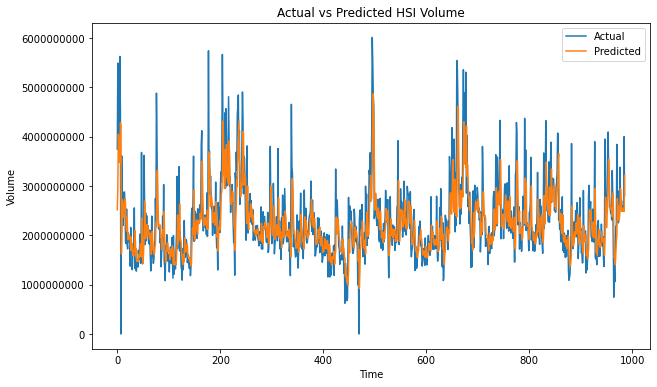

In [7]:
import matplotlib.pyplot as plt

# Make predictions on the test dataset
test_data = scaled_data[HSI_training_data_len - step:]
x_test, y_test = create_sequences(test_data, test_data, step)
predictions = model.predict(x_test)

# Inverse transform the scaled data to original scale
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted HSI Volume')
plt.xlabel('Time')
plt.ylabel('Volume')

# Manually set tick formatter to display real values without scientific notation
plt.ticklabel_format(style='plain', axis='y')

plt.legend()
plt.show()

In [8]:
import pandas as pd

# Convert actual and predicted values to DataFrame
df_actual = pd.DataFrame(y_test, columns=['Actual'])
df_predicted = pd.DataFrame(predictions, columns=['Predicted'])

# Calculate the difference between actual and predicted values
df_difference = df_actual.subtract(df_predicted['Predicted'], axis=0)
df_difference.columns = ['Difference']

# Concatenate actual, predicted, and difference DataFrames
df_comparison = pd.concat([df_actual, df_predicted, df_difference], axis=1)

# Set display options to show numbers in full precision
pd.options.display.float_format = '{:.0f}'.format

# Display the DataFrame
print(df_comparison.tail(10))

        Actual  Predicted  Difference
976 3380825500 2471879680   908945820
977 2880658500 2944962048   -64303548
978 2519017900 2779566080  -260548180
979 2697889500 2507460608   190428892
980 2488701100 2557122048   -68420948
981 2535414300 2488534528    46879772
982 2596313300 2508399360    87913940
983 2494031000 2536213760   -42182760
984 4001753000 2485523200  1516229800
985 2801014000 3217482496  -416468496


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Root Mean Squared Error (RMSE): 621534403.0159324
Mean Absolute Error (MAE): 428894232.29614604


In [10]:
# Get the most recent data
most_recent_data = scaled_data[-17:] 

# Reshape the data
x_input = np.reshape(most_recent_data, (1, most_recent_data.shape[0], 1))

# Make predictions
predicted_volume = model.predict(x_input)

# Inverse transform the predicted volume
predicted_volume = target_scaler.inverse_transform(predicted_volume)

# Convert scientific notation to regular number
predicted_volume = float("{:.2f}".format(predicted_volume[0][0]))

print("Predicted Volume for the Next Day:", predicted_volume)


1/1 [==============================] - 0s 21ms/step
Predicted Volume for the Next Day: 2772583680.0


In [14]:
# Fetching HSI data using yfinance
start_date = '2024-03-14'
end_date = '2024-03-15'
symbols = ['^HSI']
HSI_data1 = yf.download(symbols, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [15]:
print(HSI_data1)

            Open  High   Low  Close  Adj Close      Volume
Date                                                      
2024-03-14 17121 17210 16878  16962      16962  2699096400


#### error is 2772583680-2699096400=-73487280, which is -2.7% in percentage